# Práctico: Recomendación de Artistas


Integrantes: 


*   **Lucas Lissandrelo   DNI: 38502156 (Primera Parte)**
*   **Ivan Gutierrez      DNI: 33437838 (Primero y segunda parte)**

*   **Yirana Mejia        DNI: 95130042 (Primero y segunda parte)**



---


En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
from surprise import accuracy
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNWithMeans, SVD, NormalPredictor, KNNBasic, BaselineOnly, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
artist_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/artists.dat'
artist_df = pd.read_csv(artist_url, sep="\t")
artist_df.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
user_artist_plays_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/user_artists.dat'
user_artist_plays_df = pd.read_csv(user_artist_plays_url, sep="\t")
user_artist_plays_df .head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
tags_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/tags.dat'
tags_df = pd.read_csv(tags_url, sep="\t", encoding = "latin-1'")
tags_df.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
user_tagged_artists_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/user_taggedartists.dat'
user_tagged_artists_df = pd.read_csv(user_tagged_artists_url, sep="\t")
user_tagged_artists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [7]:
# General Functions
def normalize_data_frame(df, columns, max_value):
    data_frame = df[columns].copy()
    data
    scaler = preprocessing.MinMaxScaler()
    scaled_df = scaler.fit_transform(df.copy())
    scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'rating'])
    user_artist_plays_grouped_by_artist.weight = scaled_df.rating
    user_artist_plays_grouped_by_artist.columns = ['artistID', 'rating']

## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

### Artistas más escuchados:

,name,weight
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449


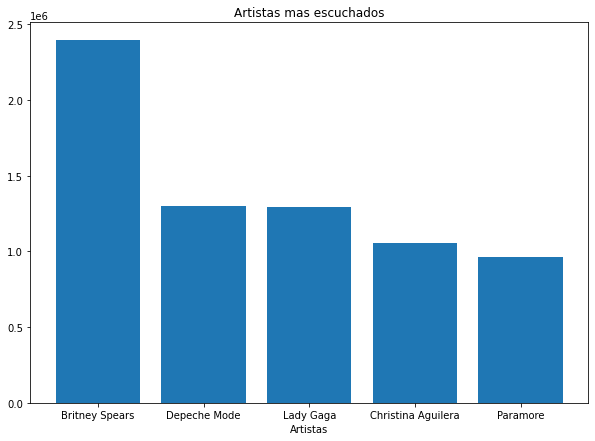

In [8]:
artist_plays_df = user_artist_plays_df.groupby(['artistID'])[['weight']].sum().reset_index()

artist_plays_sorted_df = artist_plays_df.sort_values(by='weight', ascending=False).head()
artist_most_played = artist_plays_sorted_df.merge(artist_df, left_on='artistID', right_on='id')

fig = plt.figure(figsize = (10,7))
plt.bar(artist_most_played['name'], artist_most_played['weight'])
plt.xlabel('Artistas')
plt.title('Artistas mas escuchados')
plt.show
artist_most_played[['name','weight']]

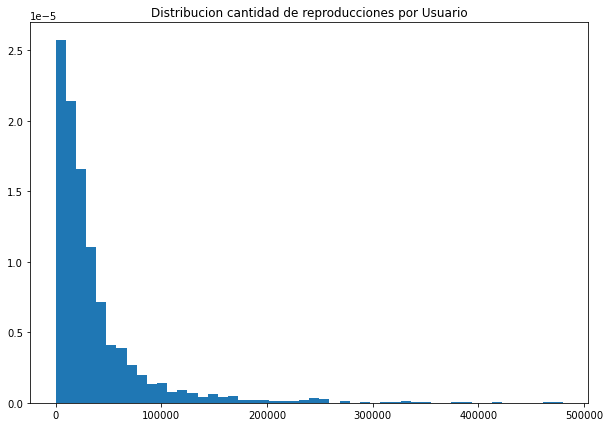

In [9]:
artist_most_played = artist_plays_sorted_df.merge(artist_df, left_on='artistID', right_on='id')
user_artist_plays_grouped_by_userid= user_artist_plays_df.groupby(['userID'])[['weight']].sum()

fig = plt.figure(figsize = (10,7))
plt.hist(user_artist_plays_grouped_by_userid['weight'], 50, density=True)
plt.title('Distribucion cantidad de reproducciones por Usuario')
plt.show
plt.show()

#### Género más escuchado:

No es posible obtener el género más escuchado porque no es un metadato propio del aritista o del tema que escuchado. El genero es asignado por un usuario según su apreciación personal, este puede varia de acuerdo a su perspectiva personal. No es una propieda objetiva para artista, sino subjetiva.
Sin embargo, consideramos que con los datos que poseemos si podriamos inferir, cual es el genero de un artista, considerado por la mayoria de los usuarios. Incluso hacerlo por año.



## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [11]:
def get_user_content_matrix(df, max_rating):
    data_frame = df.copy()
    group_by = user_artist_plays_df.groupby('userID', as_index=False).agg({"weight":"max"})
    group_by.columns=['userID', 'max_plays']
    merge = data_frame.merge(group_by, left_on='userID', right_on='userID')
    merge['rating'] = merge.apply(lambda x: x.weight/x.max_plays*10, axis=1)
    return merge[['userID','artistID','rating']]

user_content_matrix = get_user_content_matrix(user_artist_plays_df, 10)
user_content_matrix

,userID,artistID,rating
0,2,51,10.000000
1,2,52,8.420370
2,2,53,8.176187
3,2,54,7.419146
4,2,55,6.470503
...,...,...,...
92829,2100,18726,1.663376
92830,2100,18727,1.465943
92831,2100,18728,1.386969
92832,2100,18729,1.382034


In [12]:
reader = Reader(rating_scale=(0, 10))
ratings = Dataset.load_from_df(user_content_matrix[['userID', 'artistID', 'rating']], reader)

In [13]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNBaseline(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity ma

In [14]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [15]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.751659,0.362931,0.143334
SVD,1.759741,3.590276,0.134571
KNNBaseline,1.839148,0.756187,2.749385
KNNWithMeans,1.878112,0.389610,1.536778
KNNBasic,2.062998,0.361059,1.349635
NormalPredictor,2.736338,0.122814,0.130262


In [16]:
#Mejor algoritmo : BaselineOnly
trainset, testset = train_test_split(ratings, test_size=0.25)
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 2.1273


2.1272533458197502

In [17]:
artist_names = dict(zip(artist_df['id'], artist_df['name']))
#Hocico
artist_id = artist_df[artist_df.name == 'Lady Gaga'].id.iloc[0] 

similar_artists = algo.get_neighbors(artist_id, k=10)
artist_name = artist_names[artist_id]

print(f"Because you listened {artist_name}:")
for i in similar_artists:
    if i in artist_names:
        print(artist_names[i])

Because you listened Lady Gaga:
Crematory
Damien Rice
Makeshift Romeo
Poléxia
Bad Religion
Corpus Christi
Manekinekod
Kara
Deru
Ne-Yo


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

In [18]:
artists_ids = [978,67,300,157,163,192,250,89,295,299]
user_artist_plays_without = user_artist_plays_df[~user_artist_plays_df.artistID.isin(artists_ids)] 
# Verificacion
user_artist_plays_without[user_artist_plays_without.artistID.isin(artists_ids)]
artist_df[artist_df.id.isin(artists_ids)]

,id,name,url,pictureURL
61,67,Madonna,http://www.last.fm/music/Madonna,http://userserve-ak.last.fm/serve/252/340387.jpg
83,89,Lady Gaga,http://www.last.fm/music/Lady+Gaga,http://userserve-ak.last.fm/serve/252/47390093...
151,157,Michael Jackson,http://www.last.fm/music/Michael+Jackson,http://userserve-ak.last.fm/serve/252/30501527...
157,163,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...
186,192,Elton John,http://www.last.fm/music/Elton+John,http://userserve-ak.last.fm/serve/252/17079375...
244,250,Bob Marley,http://www.last.fm/music/Bob+Marley,http://userserve-ak.last.fm/serve/252/77849.jpg
289,295,Beyoncé,http://www.last.fm/music/Beyonc%C3%A9,http://userserve-ak.last.fm/serve/252/61958009...
293,299,Jennifer Lopez,http://www.last.fm/music/Jennifer+Lopez,http://userserve-ak.last.fm/serve/252/49596953...
294,300,Katy Perry,http://www.last.fm/music/Katy+Perry,http://userserve-ak.last.fm/serve/252/42128121...
969,978,Disturbed,http://www.last.fm/music/Disturbed,http://userserve-ak.last.fm/serve/252/109507.jpg


In [19]:
artist_without = artist_df[~artist_df.id.isin(artists_ids)]
# Verificacion
artist_without[artist_without.id.isin(artists_ids)]

,id,name,url,pictureURL


In [20]:
user_tagged_artists_without = user_tagged_artists_df[~user_tagged_artists_df.artistID.isin(artists_ids)] 
# Verificacion
user_tagged_artists_without[user_tagged_artists_without.artistID.isin(artists_ids)]

,userID,artistID,tagID,day,month,year


In [21]:
user_artist_tag = pd.merge(tags_df, user_tagged_artists_without,  on=['tagID'] )
artist_temp = artist_df.rename(columns={'id':'artistID'})
artist_temp = artist_temp.rename(columns={'name':'artistName'})
user_artist_tag = pd.merge(user_artist_tag, artist_temp, how='inner', on=['artistID'])
user_artist_tag = pd.merge(user_artist_tag, user_artist_plays_without, on=['artistID', 'userID'])
user_artist_tag.head()

,tagID,tagValue,userID,artistID,day,month,year,artistName,url,pictureURL,weight
0,1,metal,170,918,1,11,2008,Megadeth,http://www.last.fm/music/Megadeth,http://userserve-ak.last.fm/serve/252/8129787.jpg,1695
1,91,thrash metal,170,918,1,11,2008,Megadeth,http://www.last.fm/music/Megadeth,http://userserve-ak.last.fm/serve/252/8129787.jpg,1695
2,386,heavy metal,170,918,1,11,2008,Megadeth,http://www.last.fm/music/Megadeth,http://userserve-ak.last.fm/serve/252/8129787.jpg,1695
3,1,metal,313,918,1,5,2007,Megadeth,http://www.last.fm/music/Megadeth,http://userserve-ak.last.fm/serve/252/8129787.jpg,107
4,1,metal,491,918,1,2,2009,Megadeth,http://www.last.fm/music/Megadeth,http://userserve-ak.last.fm/serve/252/8129787.jpg,5186


### Vector de contenido:

In [22]:
artist_tags = user_artist_tag.groupby(['artistID','artistName'])['weight'].sum().reset_index()
artist_tags = artist_tags.rename(columns={'id': 'artistID', 'name':'artistName'})
artist_tags["tagsList"] = np.nan
artist_tags

,artistID,artistName,weight,tagsList
0,1,MALICE MIZER,559,NaN
1,2,Diary of Dreams,12738,NaN
2,3,Carpathian Forest,185,NaN
3,4,Moi dix Mois,1124,NaN
4,5,Bella Morte,780,NaN
...,...,...,...,...
6839,18734,The Young Gods,2064,NaN
6840,18735,Wiseblood,895,NaN
6841,18736,LOSTFREEQ,39555,NaN
6842,18737,Ciccone Youth,1680,NaN


In [ ]:
for i in artist_tags.index:
    tags = user_artist_tag[user_artist_tag["artistID"] == artist_tags["artistID"][i]]["tagValue"]
    tagLIST = tags.values.tolist()
    artist_tags["tagsList"][i] = tagLIST

In [24]:
artist_tags

,artistID,artistName,weight,tagsList
0,1,MALICE MIZER,559,"[jrock, better than lady gaga]"
1,2,Diary of Dreams,12738,"[german, gothic, darkwave, german, gothic, got..."
2,3,Carpathian Forest,185,"[black metal, norwegian black metal, true norw..."
3,4,Moi dix Mois,1124,"[j-rock, visual kei]"
4,5,Bella Morte,780,"[gothic, gothic rock, darkwave]"
...,...,...,...,...
6839,18734,The Young Gods,2064,"[alternative, electronica]"
6840,18735,Wiseblood,895,[alternative]
6841,18736,LOSTFREEQ,39555,"[ambient, downtempo, electronic, atmospheric, ..."
6842,18737,Ciccone Youth,1680,"[alternative, electronica, trip beat]"


---
### Generación de matriz de usuario contenido

In [25]:
user_artist_plays_matrix = user_artist_plays_df[["userID", "artistID", "weight"]]
user_artist_plays_matrix[user_artist_plays_matrix.artistID.isin(artists_ids)]

,userID,artistID,weight
16,2,67,3301
38,2,89,1519
113,4,157,732
119,4,163,465
148,4,192,197
...,...,...,...
92298,2088,300,9
92534,2094,89,951
92537,2094,300,1528
92636,2096,163,982


In [26]:
reader = Reader(rating_scale=(user_artist_plays_matrix.weight.min(), user_artist_plays_matrix.weight.max()))
ratings_matrix = Dataset.load_from_df(user_artist_plays_matrix[['userID', 'artistID', 'weight']], reader)
ratings_train, ratings_test = train_test_split(ratings_matrix, test_size=0.2)


In [27]:
user_artist_plays_matrix[user_artist_plays_matrix.artistID.isin(artists_ids)]

,userID,artistID,weight
16,2,67,3301
38,2,89,1519
113,4,157,732
119,4,163,465
148,4,192,197
...,...,...,...
92298,2088,300,9
92534,2094,89,951
92537,2094,300,1528
92636,2096,163,982


In [28]:
ratings_matrix

In [29]:
# Aplicando algoritmo de ejercicio 2.A - Mejor algoritmo : BaselineOnly
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
predictions = algo.fit(ratings_train).test(ratings_test)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 5134.5564


5134.556436841965

In [30]:
artist_id = artist_df[artist_df.name == 'Madonna'].id.iloc[0] 
similar_artists = algo.get_neighbors(artist_id, k=10)
similar_artists

[267, 546, 0, 1, 2, 3, 4, 5, 6, 7]

### Sistema de Recomendación

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class GenresBasedFilter(object):
    def __init__(self, artists, k=5):
        self.artist_to_idx = {row["artistName"]: idx for idx, row in artists.iterrows()}
        self.idx_to_artist = {idx: artist for artist, idx in self.artist_to_idx.items()}
        self.k = k

        tags = set(g for G in artists['tagsList'] for g in G)
        for g in tags:
            artists[g] = artists.tagsList.transform(lambda x: int(g in x))

        self.artist_tag = artists.drop(columns=['artistID', 'artistName', 'tagsList'])

    def fit(self, usr_ratings):
        self.artist_cosine_sim_ = cosine_similarity(self.artist_tag, self.artist_tag)

        self.user_ratings_ = {}
        for (userID, name, weight_rank) in usr_ratings.build_testset():
            if userID not in self.user_ratings_:
                self.user_ratings_[userID] = {}
            self.user_ratings_[userID][name] = weight_rank

        return self

    def predict(self, userID, artist):
        if not userID in self.user_ratings_ or not artist in self.artist_to_idx:
            global_mean = np.mean([
                usr_ratings for artist in self.user_ratings_.values() for usr_ratings in artist.values()
            ])
            return global_mean

        artist_idx = self.artist_to_idx[artist]
        sim_scores = list(enumerate(self.artist_cosine_sim_[artist_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:]

        sims = []

        for artist, score in sim_scores:
            if self.idx_to_artist[artist] in self.user_ratings_[userID]:
                sims.append((self.user_ratings_[userID][self.idx_to_artist[artist]], score))
                if len(sims) >= self.k:
                    break

        user_mean = np.mean(list(self.user_ratings_[userID].values()))

        pred = 0
        sim_sum = 0

        for rating, score in sims:
            pred += score * (rating - user_mean)
            sim_sum += score

        if sim_sum == 0:
            return user_mean

        return user_mean + pred / sim_sum

In [32]:
cb_model = GenresBasedFilter(artist_tags).fit(ratings_train)

### Feature Weighted Linear Stacking

In [33]:
from tqdm import tqdm_notebook

transformed_ratings_train = []

for u, m, r in tqdm_notebook(ratings_train.build_testset()):
    transformed_ratings_train.append({
        "userID": u,
        "artistID": m,
        "cb_rating": cb_model.predict(u, m),
        "cf_rating": algo.predict(u, m).est,
        "weight": r
    })

transformed_ratings_train = pd.DataFrame(transformed_ratings_train)

/home/ivan/anaconda3/envs/diplo_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [34]:
transformed_ratings_train[transformed_ratings_train.artistID.isin(artists_ids)]

,userID,artistID,cb_rating,cf_rating,weight
11,1900,67,747.804462,208.467072,171.0
96,1337,67,747.804462,596.979214,565.0
111,1337,89,747.804462,719.293606,828.0
187,468,157,747.804462,926.975600,1088.0
201,48,157,747.804462,61.145889,60.0
...,...,...,...,...,...
74199,797,67,747.804462,2.107974,2.0
74201,797,300,747.804462,19.320443,2.0
74207,1773,89,747.804462,1.000000,1.0
74228,1552,299,747.804462,1.023035,1.0


In [35]:
transformed_ratings_train.shape

(74267, 5)

In [36]:
from collections import defaultdict

user_mean_rating = defaultdict(
    lambda: transformed_ratings_train["weight"].sum(),
    transformed_ratings_train.groupby("userID")["weight"].sum().to_dict()
)
user_num_rating = defaultdict(
    lambda: 0,
    transformed_ratings_train.groupby("userID").size().to_dict()
)

def feature_function_constant():
    return 1

def feature_function_mean(user_id): # Media de rating que devuelve el usuario
    return user_mean_rating[user_id]

def feature_function_over(user_id, min_ratings=3): # Si el usuario puntuo más de 3 ratings
    return int(user_num_rating[user_id] >= min_ratings)

In [37]:
for base_model in ["cb", "cf"]:
    transformed_ratings_train["{}_rating_fc".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_train["{}_rating_fm".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

In [38]:
from sklearn.linear_model import LinearRegression

fwls_model = LinearRegression()

feature_cols = ["{}_rating_{}".format(fm, ff) for fm in ["cb", "cf"] for ff in ["fc", "fo", "fm"]]

fwls_model.fit(
    transformed_ratings_train[feature_cols],
    transformed_ratings_train["weight"]
)

LinearRegression()

In [39]:
transformed_ratings_train[transformed_ratings_train.artistID.isin(artists_ids)]

,userID,artistID,cb_rating,cf_rating,weight,cb_rating_fc,cb_rating_fm,cb_rating_fo,cf_rating_fc,cf_rating_fm,cf_rating_fo
11,1900,67,747.804462,208.467072,171.0,747.804462,5.847083e+06,747.804462,208.467072,1.630004e+06,208.467072
96,1337,67,747.804462,596.979214,565.0,747.804462,1.988412e+07,747.804462,596.979214,1.587368e+07,596.979214
111,1337,89,747.804462,719.293606,828.0,747.804462,1.988412e+07,747.804462,719.293606,1.912602e+07,719.293606
187,468,157,747.804462,926.975600,1088.0,747.804462,2.048012e+07,747.804462,926.975600,2.538708e+07,926.975600
201,48,157,747.804462,61.145889,60.0,747.804462,2.133112e+07,747.804462,61.145889,1.744186e+06,61.145889
...,...,...,...,...,...,...,...,...,...,...,...
74199,797,67,747.804462,2.107974,2.0,747.804462,4.040462e+07,747.804462,2.107974,1.138960e+05,2.107974
74201,797,300,747.804462,19.320443,2.0,747.804462,4.040462e+07,747.804462,19.320443,1.043903e+06,19.320443
74207,1773,89,747.804462,1.000000,1.0,747.804462,5.234631e+03,747.804462,1.000000,7.000000e+00,1.000000
74228,1552,299,747.804462,1.023035,1.0,747.804462,8.973654e+03,747.804462,1.023035,1.227641e+01,1.023035


### Evaluación del modelo

In [40]:
transformed_ratings_test = []

for u, m, r in tqdm_notebook(ratings_test):
    transformed_ratings_test.append({
        "userID": u,
        "artistID": m,
        "cb_rating": cb_model.predict(u, m),
        "cf_rating": algo.predict(u, m).est,
        "weight": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

/home/ivan/anaconda3/envs/diplo_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])


In [42]:
transformed_ratings_test.head(5)

,userID,artistID,cb_rating,cf_rating,weight,cb_rating_fc,cb_rating_fm,cb_rating_fo,cf_rating_fc,cf_rating_fm,cf_rating_fo,fwls_rating
0,343,5157,747.804462,425.351171,142.0,747.804462,6.704815e+06,747.804462,425.351171,3.813699e+06,425.351171,448.685395
1,808,534,747.804462,294.729121,3098.0,747.804462,1.346796e+07,747.804462,294.729121,5.308071e+06,294.729121,271.605899
2,139,190,747.804462,312.648875,93.0,747.804462,1.428980e+07,747.804462,312.648875,5.974407e+06,312.648875,288.920749
3,1485,859,747.804462,1175.059470,209.0,747.804462,1.450292e+07,747.804462,1175.059470,2.278910e+07,1175.059470,1278.527758
4,85,2361,747.804462,94.000000,160.0,747.804462,4.409803e+06,747.804462,94.000000,5.543180e+05,94.000000,76.704961


In [43]:
transformed_ratings_test[transformed_ratings_test.artistID.isin(artists_ids)]

,userID,artistID,cb_rating,cf_rating,weight,cb_rating_fc,cb_rating_fm,cb_rating_fo,cf_rating_fc,cf_rating_fm,cf_rating_fo,fwls_rating
41,1293,978,747.804462,69.894328,48.0,747.804462,1.981682e+06,747.804462,69.894328,1.852200e+05,69.894328,58.526684
117,405,89,747.804462,799.181283,4060.0,747.804462,3.537414e+07,747.804462,799.181283,3.780447e+07,799.181283,761.979723
129,1407,157,747.804462,615.004160,156.0,747.804462,1.326904e+07,747.804462,615.004160,1.091263e+07,615.004160,640.295337
157,134,67,747.804462,222.429529,45.0,747.804462,4.865964e+06,747.804462,222.429529,1.447349e+06,222.429529,222.631579
191,1648,295,747.804462,134.532310,118.0,747.804462,9.385694e+06,747.804462,134.532310,1.688515e+06,134.532310,103.699141
...,...,...,...,...,...,...,...,...,...,...,...,...
18416,1455,67,747.804462,1689.749564,729.0,747.804462,4.583892e+07,747.804462,1689.749564,1.035783e+08,1689.749564,1737.147475
18445,571,300,747.804462,1490.907394,852.0,747.804462,4.588229e+07,747.804462,1490.907394,9.147611e+07,1490.907394,1509.734177
18477,684,295,747.804462,3532.164584,10213.0,747.804462,7.398852e+07,747.804462,3532.164584,3.494759e+08,3532.164584,3714.161623
18530,702,67,747.804462,835.678956,801.0,747.804462,2.859604e+07,747.804462,835.678956,3.195636e+07,835.678956,831.362476


In [44]:
from sklearn.metrics import mean_squared_error

for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["weight"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 5134.556437
RMSE for cb model: 4304.523997
RMSE for fwls model: 5521.984404


In [45]:
# avg ratings and rating counts
avg_rating = transformed_ratings_test.groupby("artistID")["fwls_rating"].mean()
num_ratings = transformed_ratings_test.groupby("artistID")["fwls_rating"].count()
# getting counts and average ratings
fwls_ratings_counts = pd.DataFrame({"avg_rating": avg_rating,
                               "num_of_ratings": num_ratings})
# joining the new values to movie data
full_artist_data_fwls = pd.merge(transformed_ratings_test, fwls_ratings_counts, left_on="artistID", right_index=True)

In [46]:
transformed_ratings_test

,userID,artistID,cb_rating,cf_rating,weight,cb_rating_fc,cb_rating_fm,cb_rating_fo,cf_rating_fc,cf_rating_fm,cf_rating_fo,fwls_rating
0,343,5157,747.804462,425.351171,142.0,747.804462,6.704815e+06,747.804462,425.351171,3.813699e+06,425.351171,448.685395
1,808,534,747.804462,294.729121,3098.0,747.804462,1.346796e+07,747.804462,294.729121,5.308071e+06,294.729121,271.605899
2,139,190,747.804462,312.648875,93.0,747.804462,1.428980e+07,747.804462,312.648875,5.974407e+06,312.648875,288.920749
3,1485,859,747.804462,1175.059470,209.0,747.804462,1.450292e+07,747.804462,1175.059470,2.278910e+07,1175.059470,1278.527758
4,85,2361,747.804462,94.000000,160.0,747.804462,4.409803e+06,747.804462,94.000000,5.543180e+05,94.000000,76.704961
...,...,...,...,...,...,...,...,...,...,...,...,...
18562,530,7826,747.804462,747.804462,21.0,747.804462,1.037953e+06,747.804462,747.804462,1.037953e+06,747.804462,842.459901
18563,900,375,747.804462,329.410840,649.0,747.804462,1.061808e+07,747.804462,329.410840,4.677305e+06,329.410840,322.787547
18564,955,10130,747.804462,399.281057,340.0,747.804462,2.179626e+07,747.804462,399.281057,1.163784e+07,399.281057,358.443478
18565,1810,268,747.804462,747.804462,1.0,747.804462,2.245432e+07,747.804462,747.804462,2.245432e+07,747.804462,755.581108


In [47]:
artist_pivot_fwls = transformed_ratings_test.pivot_table(index='userID', 
                            columns='artistID', values='fwls_rating').fillna(0)

In [48]:
artist_pivot_fwls

artistID,1,2,3,5,6,7,8,9,10,11,...,18689,18691,18709,18711,18712,18716,18729,18737,18738,18743
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,836.119712,836.119712,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2096,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2097,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


---
### Evalución del sistema

In [49]:
# recomendation method based on correlation artists.
def get_recomendations_artist(full_artist_data_fwls, artist_pivot_fwls, artistID, n_recommendations):
    if len(full_artist_data_fwls[full_artist_data_fwls['artistID']==artistID])>0:
        # get most correlated movies
        similar_artist = artist_pivot_fwls.corrwith(artist_pivot_fwls[artistID])
        # converting to a dataframe and dropping NaN's
        similar_corr_df = pd.DataFrame({"correlation":similar_artist})
        similar_corr_df.dropna(inplace=True)

        orig = full_artist_data_fwls.copy()

        # merge with correlated dataframe but only keep specified columns
        corr_with_artist = pd.merge(left=similar_corr_df,
                                   right=orig, 
                                   on="artistID")[
            ["artistID", "correlation", "avg_rating", "num_of_ratings"]].drop_duplicates().reset_index(drop=True)

        # Order by correlation value
        result = corr_with_artist.sort_values( by='correlation', ascending=False)

        resultado = result.iloc[1:, :].head(n_recommendations)
    else:
        resultado = art_me.iloc[1:,:].head(n_recomendations)
    return resultado

In [50]:
artist_name = 'Madonna'
artist_names = dict(zip(artist_df['id'], artist_df['name']))
artist_id = artist_df[artist_df.name == artist_name].id.iloc[0] 

similar_artists = get_recomendations_artist(full_artist_data_fwls, artist_pivot_fwls, artist_id, 7)
artist_name = artist_names[artist_id]
print(f"Because you listened {artist_name}:")
for index, row in similar_artists.iterrows():
    if i in artist_names:
        print(artist_names[row.get('artistID')])

Because you listened Madonna:
Flo Rida
After One
Scooter
Inna
Akon
Busta Rhymes
Shakira
